In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score,confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [12]:
# Load dataset
data = pd.read_csv('heart.csv')
# Binary encoding for 'Sex' and 'ExerciseAngina'
data['Sex'] = data['Sex'].map({'M': 1, 'F': 0})
data['ExerciseAngina'] = data['ExerciseAngina'].map({'Y': 1, 'N': 0})
# Extract features and labels
X = data.drop(columns=['HeartDisease'])
y = data['HeartDisease']

# One-Hot Encoding for non-binary categorical features
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
encoder = OneHotEncoder(sparse=False)

if categorical_cols:  # Only encode if there are categorical features
    encoded_array = encoder.fit_transform(X[categorical_cols])
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))
    X = pd.concat([X.drop(columns=categorical_cols), encoded_df], axis=1)

X = X.to_numpy()
y = y.to_numpy()

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#X_val (10%) → Used for hyperparameter tuning.
# X_test (20%) → Used for final evaluation.
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp
)

In [5]:
# Training KNN model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# ---------------------------
#  Hyperparameter Tuning
# --------------------------

k_values = [3, 5, 11]
distance_metrics = ['euclidean', 'manhattan']

best_val_accuracy = 0
best_k = None
best_metric = None
best_model = None

for k in k_values:
    for metric in distance_metrics:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train_scaled, y_train)
        
        # Predict on the validation set
        y_val_pred = knn.predict(X_val_scaled)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        print(f"k: {k}, metric: {metric}, Validation Accuracy: {val_accuracy:.4f}")
        
        # Update best model if current model is better
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_k = k
            best_metric = metric
            best_model = knn

print("\nBest Hyperparameters:")
print(f"Best k: {best_k}")
print(f"Best distance metric: {best_metric}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

# ---------------------------
# Evaluation on Test Set
# ---------------------------
y_test_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

k: 3, metric: euclidean, Validation Accuracy: 0.8696
k: 3, metric: manhattan, Validation Accuracy: 0.9239
k: 5, metric: euclidean, Validation Accuracy: 0.8913
k: 5, metric: manhattan, Validation Accuracy: 0.9022
k: 11, metric: euclidean, Validation Accuracy: 0.8913
k: 11, metric: manhattan, Validation Accuracy: 0.8913

Best Hyperparameters:
Best k: 3
Best distance metric: manhattan
Best Validation Accuracy: 0.9239
Test Accuracy: 0.8533


c:\Users\bo2dy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\bo2dy\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [6]:
# train logistic regression
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

# predict on validation set
val_set = logistic_model.predict(X_val)
# compute accuracy
accuracy = accuracy_score(y_val, val_set)

print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.8913


c:\Users\bo2dy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
# Design Neural Network

# Scale Data and Convert to PyTorch Tensors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)          
X_val_scaled = scaler.transform(X_val)            

# Convert the scaled NumPy arrays to PyTorch tensors.
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  

x_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

x_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Neural Network Definition
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, learning_rate, num_epochs):
        super(BinaryClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.sigmoid(x)
        return x


def train_model(model, train_loader, val_loader):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=model.learning_rate)
    best_val_loss = float('inf')
    early_stopping_threshold = 5
    no_improve_epochs = 0

    for epoch in range(model.num_epochs):
        model.train()
        total_loss = 0
        for example, lab in train_loader:
            optimizer.zero_grad()
            output = model(example).squeeze()
            loss = criterion(output, lab.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        val_loss = validate_model(model, val_loader, criterion)

        print(f"Epoch [{epoch+1}/{model.num_epochs}], Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= early_stopping_threshold:
            print(f"Early stopping at epoch {epoch+1}")
            break

def validate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for example, lab in val_loader:
            output = model(example).squeeze()
            loss = criterion(output, lab.float())
            total_loss += loss.item()
    return total_loss / len(val_loader)

def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for example, _ in test_loader:
            output = model(example).squeeze()
            predicted = (output >= 0.5).int()  # Threshold at 0.5 to decide between class 0 and 1
            predictions.extend(predicted.numpy())
    return predictions


In [9]:
# Tune Hyperparameters 
input_size = X_train.shape[1]
num_epochs = 100
hidden_sizes = [16, 32, 64, 128]
lr_values = [0.001, 0.01, 0.1]

best_hidden_size = None
best_lr = None
best_accuracy = 0

for hidden_size in hidden_sizes:
    
    for lr in lr_values:
        model = BinaryClassifier(input_size, hidden_size, lr, num_epochs)
        model.train()
        train_model(model, train_loader, val_loader)
        y_pred = predict(model, val_loader)
        accuracy = accuracy_score(y_val, y_pred)
        if accuracy > best_accuracy:
            best_hidden_size = hidden_size
            best_lr = lr
            best_accuracy = accuracy
            
print(f"Best Hidden Size: {best_hidden_size}")
print(f"Best Learning Rate: {best_lr}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

Epoch [1/100], Loss: 0.6202, Val Loss: 0.6110
Epoch [2/100], Loss: 0.5911, Val Loss: 0.5831
Epoch [3/100], Loss: 0.5735, Val Loss: 0.5555
Epoch [4/100], Loss: 0.5480, Val Loss: 0.5302
Epoch [5/100], Loss: 0.5154, Val Loss: 0.5055
Epoch [6/100], Loss: 0.4947, Val Loss: 0.4809
Epoch [7/100], Loss: 0.4869, Val Loss: 0.4567
Epoch [8/100], Loss: 0.4591, Val Loss: 0.4346
Epoch [9/100], Loss: 0.4476, Val Loss: 0.4148
Epoch [10/100], Loss: 0.4303, Val Loss: 0.3986
Epoch [11/100], Loss: 0.3883, Val Loss: 0.3835
Epoch [12/100], Loss: 0.4645, Val Loss: 0.3705
Epoch [13/100], Loss: 0.3744, Val Loss: 0.3622
Epoch [14/100], Loss: 0.3525, Val Loss: 0.3527
Epoch [15/100], Loss: 0.3852, Val Loss: 0.3439
Epoch [16/100], Loss: 0.3440, Val Loss: 0.3365
Epoch [17/100], Loss: 0.3738, Val Loss: 0.3301
Epoch [18/100], Loss: 0.3272, Val Loss: 0.3252
Epoch [19/100], Loss: 0.4456, Val Loss: 0.3206
Epoch [20/100], Loss: 0.4441, Val Loss: 0.3176
Epoch [21/100], Loss: 0.4471, Val Loss: 0.3174
Epoch [22/100], Loss: 

In [10]:
# Train the model with the best hyperparameters
model = BinaryClassifier(input_size, best_hidden_size, best_lr, num_epochs)
model.train()
train_model(model, train_loader, val_loader)

# Get predictions and accuracy of the model on the test set
y_pred = predict(model, test_loader)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Neural Network: {accuracy}")

Epoch [1/100], Loss: 0.7242, Val Loss: 0.7182
Epoch [2/100], Loss: 0.7008, Val Loss: 0.6846
Epoch [3/100], Loss: 0.6500, Val Loss: 0.6556
Epoch [4/100], Loss: 0.6232, Val Loss: 0.6269
Epoch [5/100], Loss: 0.6062, Val Loss: 0.5986
Epoch [6/100], Loss: 0.5725, Val Loss: 0.5709
Epoch [7/100], Loss: 0.5410, Val Loss: 0.5451
Epoch [8/100], Loss: 0.5252, Val Loss: 0.5187
Epoch [9/100], Loss: 0.5023, Val Loss: 0.4946
Epoch [10/100], Loss: 0.4909, Val Loss: 0.4723
Epoch [11/100], Loss: 0.4654, Val Loss: 0.4523
Epoch [12/100], Loss: 0.4508, Val Loss: 0.4331
Epoch [13/100], Loss: 0.4236, Val Loss: 0.4168
Epoch [14/100], Loss: 0.3961, Val Loss: 0.4012
Epoch [15/100], Loss: 0.3809, Val Loss: 0.3871
Epoch [16/100], Loss: 0.3631, Val Loss: 0.3740
Epoch [17/100], Loss: 0.3579, Val Loss: 0.3629
Epoch [18/100], Loss: 0.3470, Val Loss: 0.3528
Epoch [19/100], Loss: 0.3475, Val Loss: 0.3444
Epoch [20/100], Loss: 0.3739, Val Loss: 0.3372
Epoch [21/100], Loss: 0.4355, Val Loss: 0.3323
Epoch [22/100], Loss: 

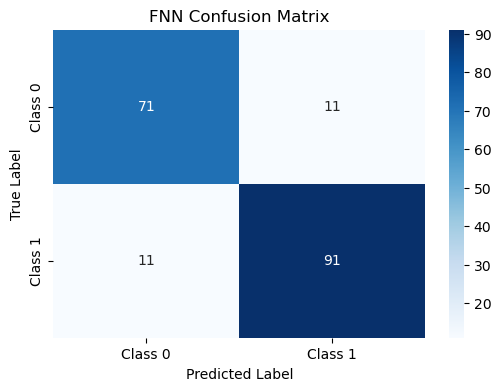

F1 Score: 0.8922


In [11]:
# Plot Confusion Matrix

conf_matrix = confusion_matrix(y_test, y_pred)
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(conf_matrix, "FNN Confusion Matrix")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")